In [2]:
import emcee, copy
import numpy as np
from astropy.table import Table,Column
import matplotlib.pyplot as plt
from astropy.io import ascii

   MJD     lum    dlum ...        Mbolerr               t_exp       
--------- ------ ----- ... ---------------------- ------------------
58980.513 41.887 0.016 ... 0.00041483037696660066 5.5129999999990105
58980.722 41.884 0.016 ... 0.00041486008977175055  5.722000000001572
 58981.18 41.871 0.016 ...  0.0004149888944615605  6.180000000000291
58981.199  41.87 0.016 ... 0.00041499880582756155  6.199000000000524
 58982.18 41.851 0.016 ... 0.00041518721177510697  7.180000000000291
58982.707 41.841 0.039 ...  0.0010122607012260701  7.707000000002154
58983.207 41.826 0.016 ...  0.0004154353751255201  8.207000000002154
 58983.28 41.822 0.016 ... 0.00041547510879441445  8.279999999998836
58984.181  41.81 0.016 ... 0.00041559435541736425  9.180999999996857
 58984.72 41.803 0.016 ...   0.000415663947563572  9.720000000001164
      ...    ...   ... ...                    ...                ...
 59250.27 39.894 0.418 ...   0.011378853963001957  275.2699999999968
59255.039 39.846 0.386 ...   0.010

  2%|▏         | 109/5000 [00:03<02:22, 34.32it/s]C:\Users\jvasq\AppData\Local\Temp\ipykernel_14832\2316198786.py:9: RuntimeWarning: overflow encountered in exp
  return(-a/(1. + np.exp((time-tpt)/w))+p*time+m)
100%|██████████| 5000/5000 [02:21<00:00, 35.37it/s]


Best-fit parameters:
Param: 1.1794535331316411 + 0.07255038934172298 - 0.07286010599526271
Param: 63.221256956545574 + 0.7129189934648323 - 0.6145063852765276
Param: 3.875153471613964 + 0.8071143200033424 - 0.6345698821582371
Param: 0.013256991828397555 + 0.00030578339985568893 - 0.000296192765964794
Param: -14.58262533216606 + 0.07643922848940043 - 0.07727286752207618
[1.1794535331316411, 63.221256956545574, 3.875153471613964, 0.013256991828397555, -14.58262533216606]
   MJD     lum    dlum ...        Mbolerr               t_exp       
--------- ------ ----- ... ---------------------- ------------------
58980.513 41.887 0.016 ... 0.00041483037696660066 5.5129999999990105
58980.722 41.884 0.016 ... 0.00041486008977175055  5.722000000001572
 58981.18 41.871 0.016 ...  0.0004149888944615605  6.180000000000291
58981.199  41.87 0.016 ... 0.00041499880582756155  6.199000000000524
 58982.18 41.851 0.016 ... 0.00041518721177510697  7.180000000000291
58982.707 41.841 0.039 ...  0.0010122607012

<Figure size 640x480 with 0 Axes>

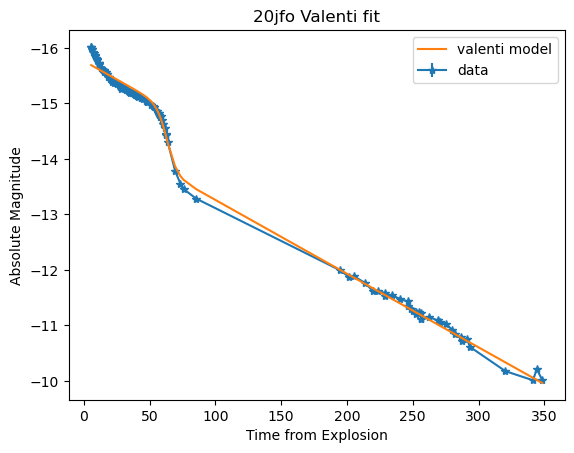

In [3]:
plt.clf()

# Input parameters - superbol file and MJD explosion/discovery date
data_file = 'logL_obs_2020jfo_SDAUBgVriz.txt' 
mjd_start=58975

def valenti_model(time, theta):
    a, tpt, w, p, m = theta
    return(-a/(1. + np.exp((time-tpt)/w))+p*time+m)

def lnlikelihood(theta, lum, dlum, time):
    model_lum = valenti_model(time, theta)
    
    # Set parameter range value
    a, tpt, w, p, m = theta
    if a<0.01: return(-np.inf)
    if a>10.0: return(-np.inf)
    if tpt<10.0: return(-np.inf)
    if w<0.01: return(-np.inf)
    
    inv_sigma = 1./dlum**2
    return(-0.5 * np.sum((lum-model_lum)**2 * inv_sigma))

def load_table(data_file, mjd_start=mjd_start, mask_date=5):
    # The code will automatically mask data mask_date days from the input reference date.
    # Change this value in order to adjust the amount of data that's included/excluded
    
    table = Table.read(data_file, format='ascii',names=('MJD','lum','dlum'))
    #print(table)
    # Want to fit versus a magnitude rather than actual luminosity, so convert lum to Mbol
    # Here 83.9605452803 = 2.5*log10(3.839e33) for Solar luminosity
    # 4.74 is bolometric luminosity of the Sun
    table['MJD'] = table['MJD']
    Mbol = -2.5*table['lum'] + 83.9605452803 + 4.74
    Mbolerr = 1.086 * (table['dlum'] / table['lum'])

    
    table.add_column(Column(Mbol, name='Mbol'))
    table.add_column(Column(Mbolerr, name='Mbolerr'))
    
    newcol=Column(table['MJD'].data-mjd_start,name='t_exp')
    table.add_column(newcol)
    
    mask = table['t_exp']>mask_date
    table=table[mask]
    print(table)
    return(table)

def mcmc_valenti(data_file, ndim=5, nwalkers=100, inflate_errors=0.1):
    
    # I'm adding a parameter to inflate the error bars because the code appears to underfit the
    # late time decline due to nickel, which is primarily what we're interested in
    
    params = [1.7391707763335567, 111.06179709805089, 7.203197652533321, 0.008194307783125725, -13.583601384015793]
    pos = [params + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]
    
    table = load_table(data_file)
    mask = np.abs(table['MJD'] - mjd_start) < 1
    table = table[~mask]
    table['Mbolerr'] = np.sqrt(table['Mbolerr']**2+inflate_errors**2)
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlikelihood, 
                                    args=(table['Mbol'],
                                          table['Mbolerr'],
                                          table['t_exp']))
    
    sampler.run_mcmc(pos, 5000, progress=True)
    samples = sampler.chain[:, 99:, :].reshape((-1, ndim))
    
    return(samples)

def get_param_uncertainties(samples):
    
    vals = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                                 zip(*np.percentile(samples, [16, 50, 84],
                                                    axis=0)))
    
    vals = [v for v in vals]
    
    return(vals)
    
samples=mcmc_valenti(data_file)
params=get_param_uncertainties(samples)
   

print('Best-fit parameters:')
for p in copy.copy(params):
    print('Param: {0} + {1} - {2}'.format(p[0], p[1], p[2]))

best_fit=[p[0] for p in copy.copy(params)]
print(best_fit)
table = load_table(data_file)
plt.figure() 

plt.errorbar(table['MJD']-mjd_start, table['Mbol'], yerr=table['Mbolerr'], marker='*', zorder=5, label = 'data')

    
model_lum=valenti_model(table['MJD']-mjd_start, best_fit)

plt.plot(table['MJD']-mjd_start, model_lum, zorder=10, label = 'valenti model')

#plt.ylim([-14,-20])
plt.ylabel('Absolute Magnitude')
plt.xlabel('Time from Explosion')
plt.legend()
plt.title('20jfo Valenti fit')
plt.gca().invert_yaxis()

plt.show()

In [5]:
luminosity=[]
# Using 220.0 rest-frame days as reference time
lightcurve_ref_time = mjd_start + 220
print(f'lightcurve_ref_time:{lightcurve_ref_time}')
for s in samples:
    abs_mag=valenti_model(lightcurve_ref_time, s)
    luminosity.append(3.839e33 * 10**(-0.4 * (abs_mag-4.74)))
print(f'len lum:{len(luminosity)}')

data = np.percentile(luminosity, [16, 50, 84])
lum=data[1]
errhi=data[2]-data[1]
errlo=data[1]-data[0] 
print('Luminosity (1e39 erg/s)=','%1.2f'%(lum*1.0e-39),'+','%1.2f'%(errhi*1.0e-39),'-','%1.2f'%(errlo*1.0e-39))
print(data) 
print(errhi)
print(errlo)

# Heating rate for Co-56 decay in erg/s/g
epsilon = 6.8e9
# Mass of Co-56 in grams at 270 days
mass_Co56 = np.array(luminosity) / epsilon

# Radioactive decay timescale for Ni-56 and Co-56.  These are equal to ln(2)/(half-life)
# Half-life for Ni-56 is 6.075 days, Half-life for Co-56 is 55.93983 days
lambda_Co56 = np.log(2)/55.9383
lambda_Ni56 = np.log(2)/6.075

# Mass of Ni-56 at t=0
mass_Ni56 = mass_Co56 * (lambda_Co56 - lambda_Ni56)/lambda_Ni56 * (np.exp(-lambda_Ni56 * lightcurve_ref_time) - np.exp(-lambda_Co56 * lightcurve_ref_time))**-1
data = np.percentile(mass_Ni56, [16, 50, 84])
print(data)
mass=data[1]
errhi=data[2]-data[1]
errlo=data[1]-data[0] 
print('Mass (Msun)=','%1.4f'%(mass/(1.989e33)),'+','%1.4f'%(errhi/(1.989e33)),'-','%1.4f'%(errlo/(1.989e33)))

lightcurve_ref_time:59195


C:\Users\jvasq\AppData\Local\Temp\ipykernel_14832\2316198786.py:9: RuntimeWarning: overflow encountered in exp
  return(-a/(1. + np.exp((time-tpt)/w))+p*time+m)


len lum:490100
Luminosity (1e39 erg/s)= 0.00 + 0.00 - 0.00
[1.60121790e-280 2.59663456e-273 2.50893102e-266]
2.5089307650506798e-266
2.596634399782845e-273


C:\Users\jvasq\AppData\Local\Temp\ipykernel_14832\1908498221.py:30: RuntimeWarning: overflow encountered in double_scalars
  mass_Ni56 = mass_Co56 * (lambda_Co56 - lambda_Ni56)/lambda_Ni56 * (np.exp(-lambda_Ni56 * lightcurve_ref_time) - np.exp(-lambda_Co56 * lightcurve_ref_time))**-1
C:\Users\jvasq\AppData\Local\Temp\ipykernel_14832\1908498221.py:30: RuntimeWarning: invalid value encountered in multiply
  mass_Ni56 = mass_Co56 * (lambda_Co56 - lambda_Ni56)/lambda_Ni56 * (np.exp(-lambda_Ni56 * lightcurve_ref_time) - np.exp(-lambda_Co56 * lightcurve_ref_time))**-1
c:\Users\jvasq\anaconda3\envs\TypeII\lib\site-packages\numpy\lib\function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


[nan nan nan]
Mass (Msun)= nan + nan - nan
